# Selection of a calibrant

In this tutorial we will see how to select a calibrant for a given experimental setup.

## Experimental setup

The experimental setup is a classical protein crystallography setup with:

 * Large Pilatus 6M detector on a translation table
 * The small and intense beam of ~50 microns in size has a wavelength of 1 Angstrom
 * The detector is in *normal* condition: orthogonal to the beam and centered in the middle of the detector.

The scientist in charge of this beamline want to ensure all encoders are working properly and needs to validate the setup for distances between 10cm and 80cm. 
He will buy reference material from NIST but he does not know which calibrant is best suited for his setup. 
We will assume all reference material sold by NIST are equally suitable for ray position (no issue with grain size, ...).

The calibration works best in pyFAI if more than one Debye-Scherrer ring is seen on the detector.

## Define the detector

In [1]:
import time
start_time = time.time()
import pyFAI, pyFAI.detectors
print("PyFAI version", pyFAI.version)
dete = pyFAI.detectors.Pilatus6M()
print(dete)

PyFAI version 0.18.0
Detector Pilatus 6M	 PixelSize= 1.720e-04, 1.720e-04 m


## Select reference materials

The NIST sells different [Standard Refrence Materials](http://www.nist.gov/mml/mmsd/upload/852_08_81b.pdf), among them 
Silicon (SRM640), Lanthanum hexaboride (SRM660),  Alumina (SRM676) and Ceria (SRM674) are commonly used. 
Many other exists: Cr203, TiO2, Zn0, SiO2, ... Evaluating them is left as an exercise.


In [2]:
import pyFAI.calibrant
print(pyFAI.calibrant.ALL_CALIBRANTS)

Calibrants available: C14H30O, Si_SRM640c, LaB6, cristobaltite, Ni, Au, CeO2, Si_SRM640a, ZnO, alpha_Al2O3, Al, Si_SRM640e, Si_SRM640d, quartz, AgBh, Si_SRM640b, TiO2, NaCl, LaB6_SRM660a, mock, PBBA, CuO, LaB6_SRM660c, CrOx, Cr2O3, Si, LaB6_SRM660b, Si_SRM640


You may wonder where the names of the calibrant came from and how they have been established. 

The name of all calibrant available in your version of pyFAI can be listed by just printing out the content of ALL_CALIBRANTS. New calibrant may have been added in pyFAI in more recent releases, just have a look at the [developent web page](https://github.com/silx-kit/pyFAI/tree/master/pyFAI/resources/calibration).

Most of those calibrant files, which contain the *d-spacing* in Angstrom between Miller plans, have been prepared from the unit cell of the compount, found in publication. This publication is referenced in the header of the file.
If one wishes to regenerate those files, the *pyFAI.calibrant.Cell* class may be used for.

We will now focus on a subset of calibrant, instanciate them and put them into a dictionnary. The Python construct used here is called *dict-comprehension* and allows the creation and population of a dictionnary in a single line.

In [3]:
cals = dict((name,pyFAI.calibrant.ALL_CALIBRANTS(name)) for name in ("Si", "LaB6", "CeO2", "alpha_Al2O3"))
for k,v in cals.items():
    print(k,": ", v)

Si :  Si Calibrant with 708 reflections 
LaB6 :  LaB6 Calibrant with 1441 reflections 
CeO2 :  CeO2 Calibrant with 41 reflections 
alpha_Al2O3 :  alpha_Al2O3 Calibrant with 31 reflections 


To be able to use those calibrants, one needs to define the wavelength used, here 1 Angstrom.

In [4]:
wl = 1e-10

for k,v in cals.items():
    v.wavelength = wl
    print(k,": ", v)

Si :  Si Calibrant with 28 reflections at wavelength 1e-10
LaB6 :  LaB6 Calibrant with 59 reflections at wavelength 1e-10
CeO2 :  CeO2 Calibrant with 41 reflections at wavelength 1e-10
alpha_Al2O3 :  alpha_Al2O3 Calibrant with 31 reflections at wavelength 1e-10


## Short distance images

The shortest the detector can come to the sample is about 10cm (to leave space for the beamstop).
We will generate images of diffraction at this distance. 

For the display of images we will use *matplotlib* inlined and some utilities from pyFAI to display images.

In [5]:
p1, p2, p3 = dete.calc_cartesian_positions()
poni1 = p1.mean()
poni2 = p2.mean()
print("Detector center at %s, %s"%(poni1, poni2))
from pyFAI.azimuthalIntegrator import AzimuthalIntegrator
ai_short = AzimuthalIntegrator(dist=0.1, poni1=poni1, poni2=poni2,detector=dete)
print(ai_short)

Detector center at 0.21732217, 0.21181805
Detector Pilatus 6M	 PixelSize= 1.720e-04, 1.720e-04 m
SampleDetDist= 1.000000e-01m	PONI= 2.173222e-01, 2.118181e-01m	rot1=0.000000  rot2= 0.000000  rot3= 0.000000 rad
DirectBeamDist= 100.000mm	Center: x=1231.500, y=1263.501 pix	Tilt=0.000 deg  tiltPlanRotation= 0.000 deg


In [6]:
%pylab nbagg
from pyFAI.gui import jupyter

Populating the interactive namespace from numpy and matplotlib


<IPython.core.display.Javascript object>


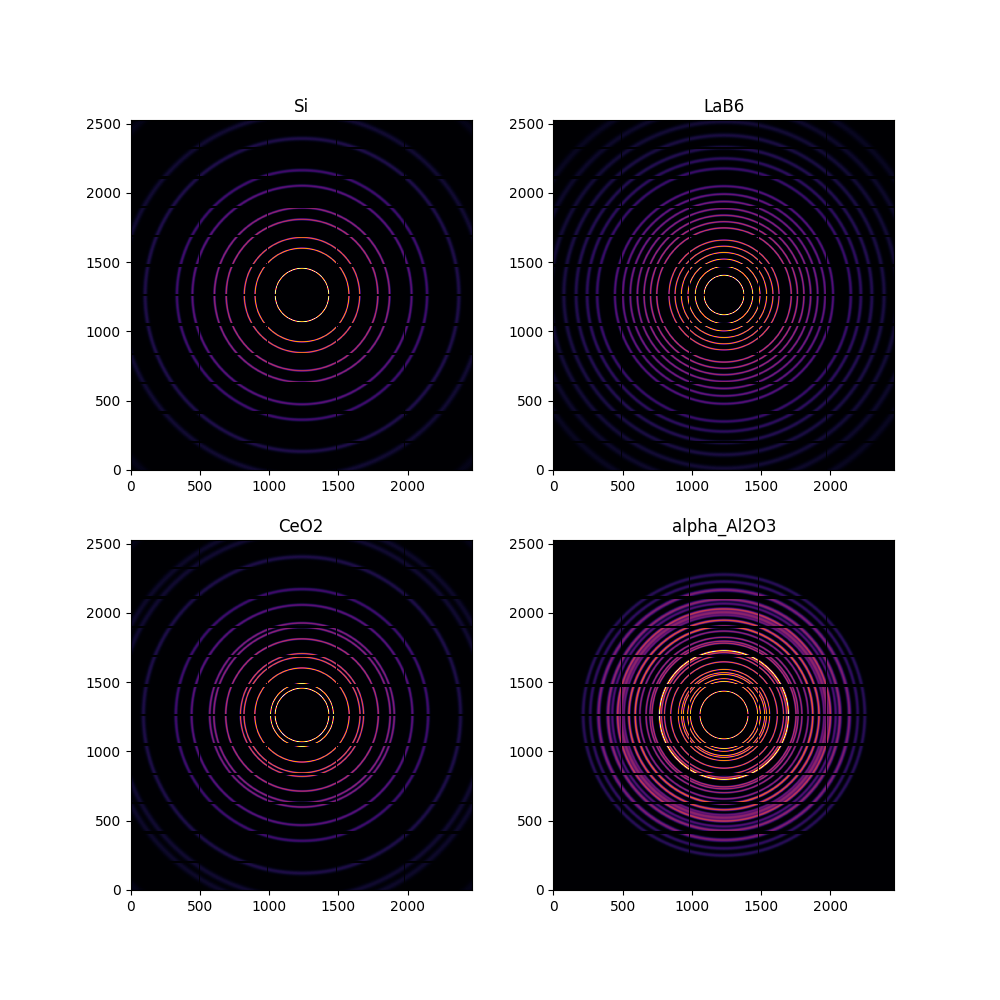

In [7]:
fig, ax = subplots(2, 2, figsize=(10,10))
for idx, key in enumerate(cals):
    cal = cals[key]
    img = cal.fake_calibration_image(ai_short)
    jupyter.display(img, label=key, ax=ax[idx//2, idx%2])

As one can see, there are plenty of rings on the image: it should be easy to calibrate.
By moving further away the detector, the number of rings will decrease.

## Long distance images ##

To keep good calibration one should have at lease two rings for the calibration.
The longest distance from sample to the detector is 80cm.

In [8]:
ai_long = AzimuthalIntegrator(dist=0.8, poni1=poni1, poni2=poni2, detector=dete)
print(ai_long)

Detector Pilatus 6M	 PixelSize= 1.720e-04, 1.720e-04 m
SampleDetDist= 8.000000e-01m	PONI= 2.173222e-01, 2.118181e-01m	rot1=0.000000  rot2= 0.000000  rot3= 0.000000 rad
DirectBeamDist= 800.000mm	Center: x=1231.500, y=1263.501 pix	Tilt=0.000 deg  tiltPlanRotation= 0.000 deg


<IPython.core.display.Javascript object>


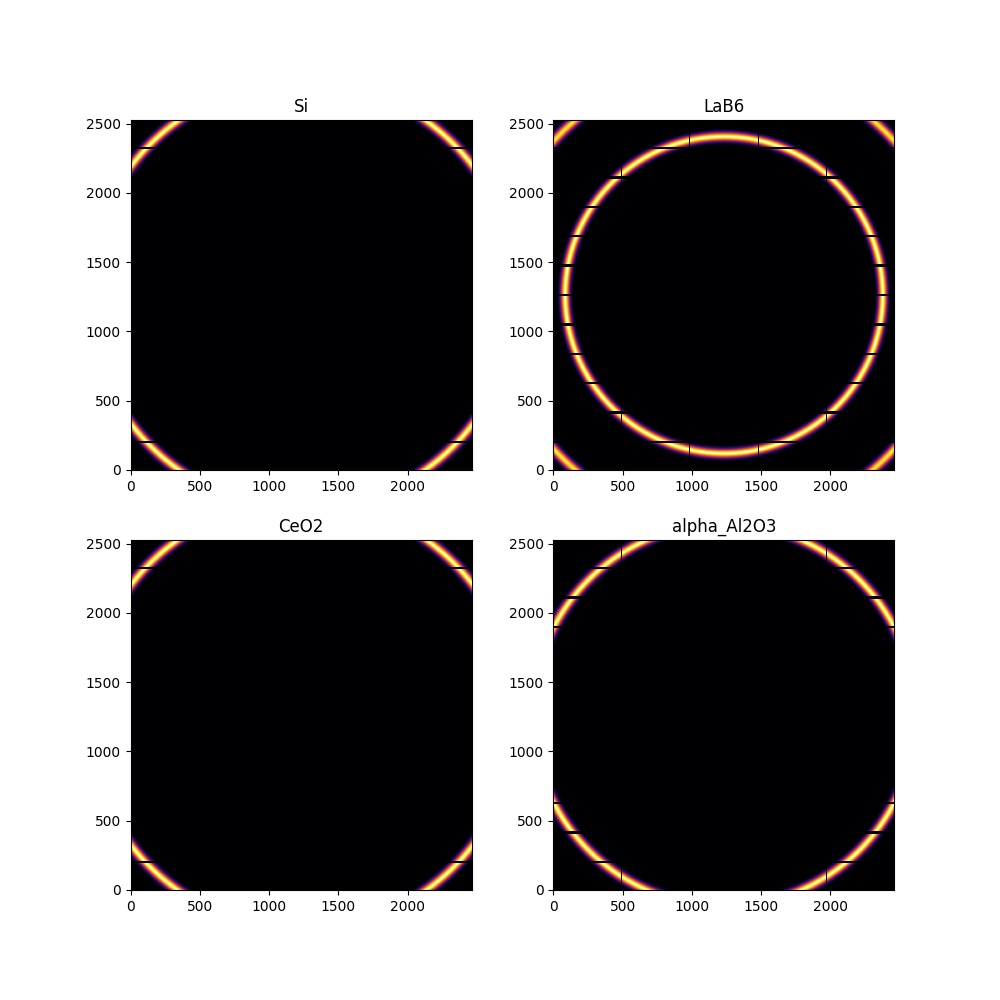

In [9]:
fig, ax = subplots(2, 2, figsize=(10,10))
for idx, key in enumerate(cals):
    cal = cals[key]
    img = cal.fake_calibration_image(ai_long)
    jupyter.display(img, label=key, ax=ax[idx//2, idx%2])

The most adapted calibrant is probably the *LaB6* as 2 rings are still visible at 80 cm from the detector.

## Integration of the pattern for the two extreme cases ##
We can integrate the image for the two extreme cases:

<IPython.core.display.Javascript object>


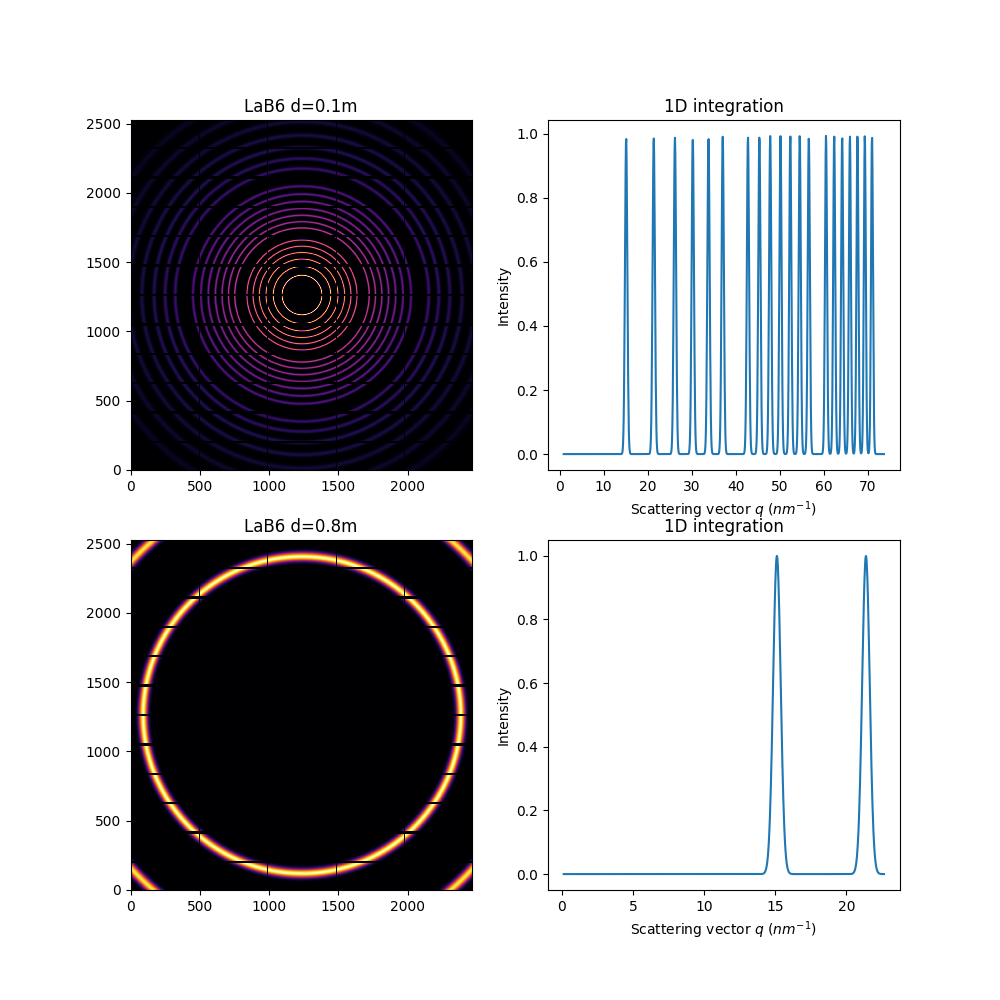

In [10]:
lab6 = cals["LaB6"]
ai_short.wavelength = ai_long.wavelength = wl

fig, ax = subplots(2, 2, figsize=(10,10))
img_short = lab6.fake_calibration_image(ai_short)
jupyter.display(img_short, label="LaB6 d=0.1m", ax=ax[0,0])
jupyter.plot1d(ai_short.integrate1d(img_short,1000), ax=ax[0,1])

img_long = lab6.fake_calibration_image(ai_long)
jupyter.display(img_long, label="LaB6 d=0.8m", ax=ax[1,0])
jupyter.plot1d(ai_long.integrate1d(img_long,1000), ax=ax[1,1])


## Conclusion ##
The best calibrant in this case is probably LaB6.

In [11]:
print("Total execution time: %.3fs"%(time.time()-start_time))

Total execution time: 6.447s
